In [1]:
import os
import csv
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.applications import ResNet50V2
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
from PIL import Image
from keras_vggface.vggface import VGGFace

In [2]:
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

### Read the Dataset

In [3]:
# Load dataset
data = pd.read_csv('.\Data\data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206 entries, 0 to 4205
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   4206 non-null   int64  
 1   bmi          4206 non-null   float64
 2   gender       4206 non-null   object 
 3   is_training  4206 non-null   int64  
 4   name         4206 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 164.4+ KB


In [5]:
data.head()

,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,Male,1,img_0.bmp
1,1,26.453720,Male,1,img_1.bmp
2,2,34.967561,Female,1,img_2.bmp
3,3,22.044766,Female,1,img_3.bmp
4,4,37.758789,Female,1,img_4.bmp


In [6]:
data.gender = data.gender.map({'Male':1, 'Female':0})

In [7]:
data.head()

,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,1,1,img_0.bmp
1,1,26.453720,1,1,img_1.bmp
2,2,34.967561,0,1,img_2.bmp
3,3,22.044766,0,1,img_3.bmp
4,4,37.758789,0,1,img_4.bmp


In [8]:
train_data = data[data['is_training']==1].reset_index(drop=True)
test_data = data[data['is_training']==0].reset_index(drop=True)

In [9]:
import matplotlib.pyplot as plt

In [10]:
train_data.head()

,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,1,1,img_0.bmp
1,1,26.453720,1,1,img_1.bmp
2,2,34.967561,0,1,img_2.bmp
3,3,22.044766,0,1,img_3.bmp
4,4,37.758789,0,1,img_4.bmp


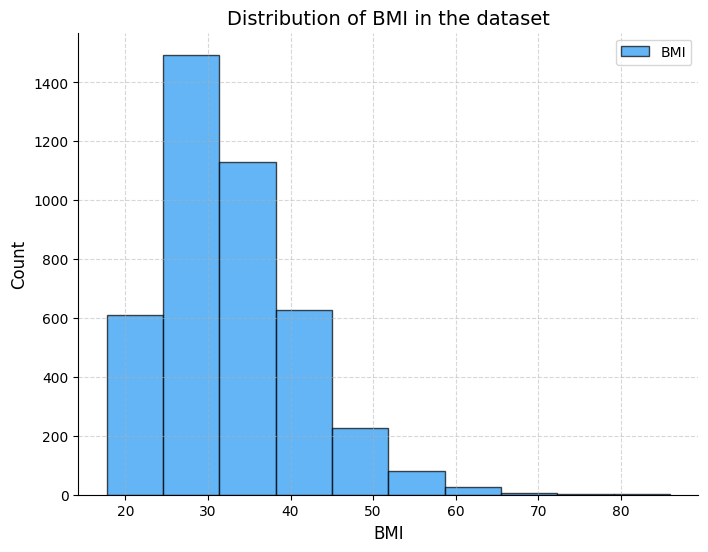

In [11]:
bmi_values = data['bmi']

# Set the desired number of bins
num_bins = 10

# Set the figure size and create the histogram plot
plt.figure(figsize=(8, 6))
plt.hist(bmi_values, bins=num_bins, edgecolor='black', color='#2196f3', alpha=0.7)

# Add labels and title
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of BMI in the dataset', fontsize=14)

# Set grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Add a legend
plt.legend(['BMI'], loc='best', fontsize=10)

# Remove the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Show the plot
plt.show()




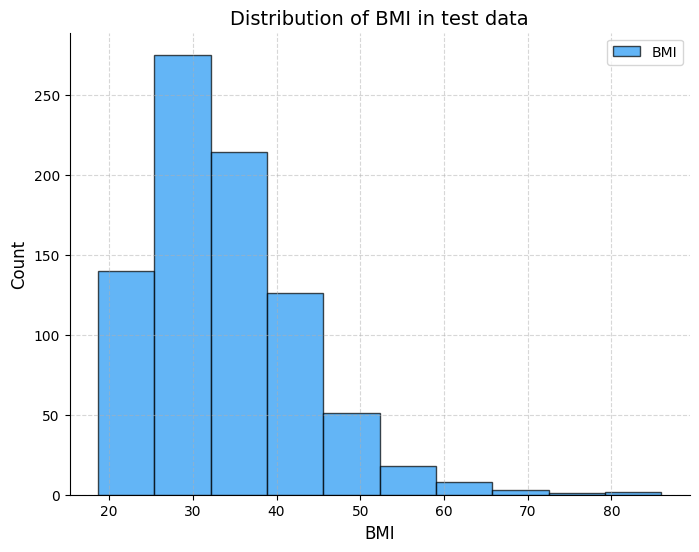

In [12]:
bmi_values = test_data['bmi']

# Set the desired number of bins
num_bins = 10

# Set the figure size and create the histogram plot
plt.figure(figsize=(8, 6))
plt.hist(bmi_values, bins=num_bins, edgecolor='black', color='#2196f3', alpha=0.7)

# Add labels and title
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of BMI in test data', fontsize=14)

# Set grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Add a legend
plt.legend(['BMI'], loc='best', fontsize=10)

# Remove the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Show the plot
plt.show()



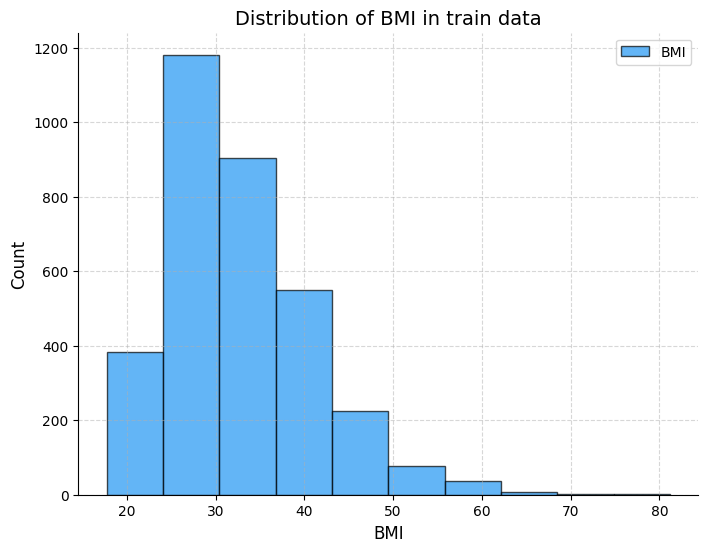

In [13]:
bmi_values = train_data['bmi']

# Set the desired number of bins
num_bins = 10

# Set the figure size and create the histogram plot
plt.figure(figsize=(8, 6))
plt.hist(bmi_values, bins=num_bins, edgecolor='black', color='#2196f3', alpha=0.7)

# Add labels and title
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of BMI in train data', fontsize=14)

# Set grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Add a legend
plt.legend(['BMI'], loc='best', fontsize=10)

# Remove the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Show the plot
plt.show()




### Train and test data generator

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    height_shift_range=0.5,
    rotation_range=90,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    validation_split=0.2
)

In [15]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='.\Data\Images',
    x_col="name",
    y_col='bmi',
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(224,224),
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='.\Data\Images',
    x_col="name",
    y_col='bmi',
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(224,224),
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = '.\Data\Images',
    x_col = 'name',
    y_col = 'bmi',
    target_size = (224,224),
    batch_size = 32,
    class_mode ='raw')

Found 2568 validated image filenames.
Found 642 validated image filenames.
Found 752 validated image filenames.


c:\Users\harsh\anaconda3\envs\tfdml_plugin\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 158 invalid image filename(s) in x_col="name". These filename(s) will be ignored.
  warnings.warn(
c:\Users\harsh\anaconda3\envs\tfdml_plugin\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 158 invalid image filename(s) in x_col="name". These filename(s) will be ignored.
  warnings.warn(
c:\Users\harsh\anaconda3\envs\tfdml_plugin\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 86 invalid image filename(s) in x_col="name". These filename(s) will be ignored.
  warnings.warn(


In [16]:
resnet_50_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze all the layers
for layer in resnet_50_model.layers:
    layer.trainable = False

In [18]:
for layer in resnet_50_model.layers[-13:]:
    layer.trainable = True

In [19]:
model = Sequential()
model.add(resnet_50_model)
model.add(Conv2D(padding='same', kernel_size=(2,2), filters=32, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(padding='same', kernel_size=(3,3), strides=2, filters=64, activation='relu'))
model.add(Flatten())
model.add(Dense(units = 1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=512, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='linear'))
model.add(Dense(units=1, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          262176    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1024)              263168    
                                                        

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics='mse')

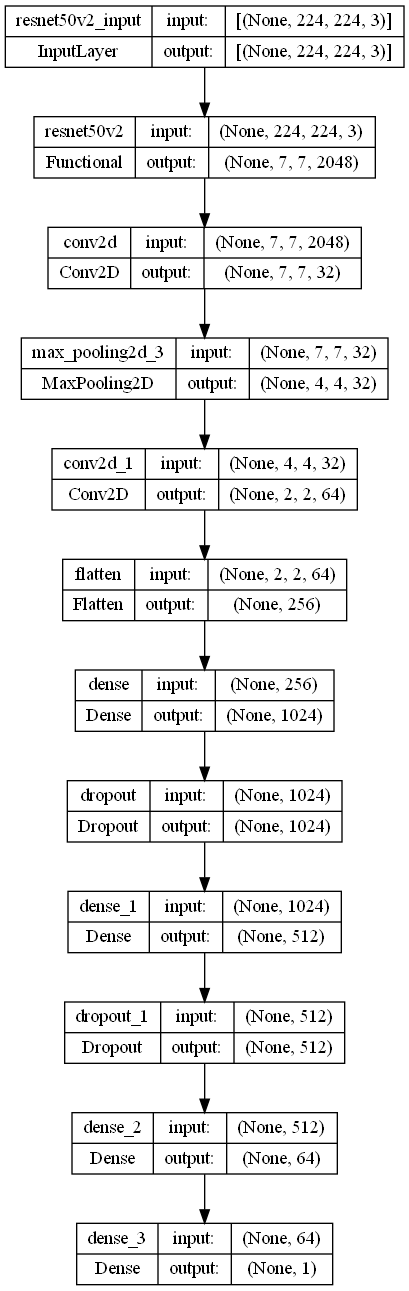

In [21]:
plot_model(model=model, show_shapes=True)

In [22]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='.\\Model\\resent50v3\\model_final.h5',
                                                          save_best_only=True,
                                                          save_weights_only=False,
                                                          monitor='val_loss',
                                                          verbose=1,
                                                          mode='min')

In [23]:
final_model_history = model.fit(train_generator, 
          validation_data=valid_generator, 
          validation_batch_size=48,
          verbose=1,
          epochs=50,
          steps_per_epoch=len(train_generator),
          validation_steps=len(valid_generator),
          callbacks=[checkpoint_callback])

Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 196.1772 - mse: 196.1772
Epoch 1: val_loss improved from inf to 88.15762, saving model to .\Model\resent50v3\model_final.h5
81/81 [==============================] - 54s 635ms/step - loss: 196.1772 - mse: 196.1772 - val_loss: 88.1576 - val_mse: 88.1576
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 76.3462 - mse: 76.3462
Epoch 2: val_loss improved from 88.15762 to 86.16016, saving model to .\Model\resent50v3\model_final.h5
81/81 [==============================] - 27s 329ms/step - loss: 76.3462 - mse: 76.3462 - val_loss: 86.1602 - val_mse: 86.1602
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 70.2036 - mse: 70.2036
Epoch 3: val_loss improved from 86.16016 to 80.74483, saving model to .\Model\resent50v3\model_final.h5
81/81 [==============================] - 26s 317ms/step - loss: 70.2036 - mse: 70.2036 - val_loss: 80.7448 - val_mse: 80.7448
Epoch 4/50
81/81 [====================

In [24]:
inception_values = pd.DataFrame(final_model_history.history).to_csv('inception.csv')

inception_values = pd.read_csv('inception.csv')

In [26]:
import numpy as np

In [27]:
inception_values['rmse'] = np.sqrt(inception_values['mse'])

In [29]:
inception_values['vl_rmse'] = np.sqrt(inception_values['val_mse'])

In [30]:
inception_values.head()

,Unnamed: 0,loss,mse,val_loss,val_mse,rmse,vl_rmse
0,0,196.177155,196.177155,88.157616,88.157616,14.006326,9.389229
1,1,76.346214,76.346214,86.160156,86.160156,8.737632,9.282250
2,2,70.203629,70.203629,80.744835,80.744835,8.378761,8.985813
3,3,65.531258,65.531258,67.653221,67.653221,8.095138,8.225158
4,4,64.473824,64.473824,59.165775,59.165775,8.029559,7.691929


In [31]:
bmi_final = inception_values.copy()

In [36]:
bmi_final = bmi_final[bmi_final['val_loss'] != 82.582718]

In [45]:
bmi_final = bmi_final[bmi_final['vl_rmse'] != 9.087503]

In [47]:
bmi_final.drop(index=42, inplace=True)

In [48]:
bmi_final.tail(10)

,Unnamed: 0,loss,mse,val_loss,val_mse,rmse,vl_rmse
39,39,38.230034,38.230034,53.860565,53.860565,6.183044,7.338976
40,40,37.321186,37.321186,62.345184,62.345184,6.109107,7.895897
41,41,38.635773,38.635773,49.957584,49.957584,6.215768,7.068068
43,43,40.510948,40.510948,50.636612,50.636612,6.364821,7.115941
44,44,36.501518,36.501518,57.877705,57.877705,6.041649,7.607740
45,45,37.428429,37.428429,50.795567,50.795567,6.117878,7.127101
46,46,37.380920,37.380920,53.725788,53.725788,6.113994,7.329788
47,47,35.730480,35.730480,51.061001,51.061001,5.977498,7.145698
48,48,36.167072,36.167072,53.886723,53.886723,6.013907,7.340758
49,49,36.741753,36.741753,52.649731,52.649731,6.061498,7.256013


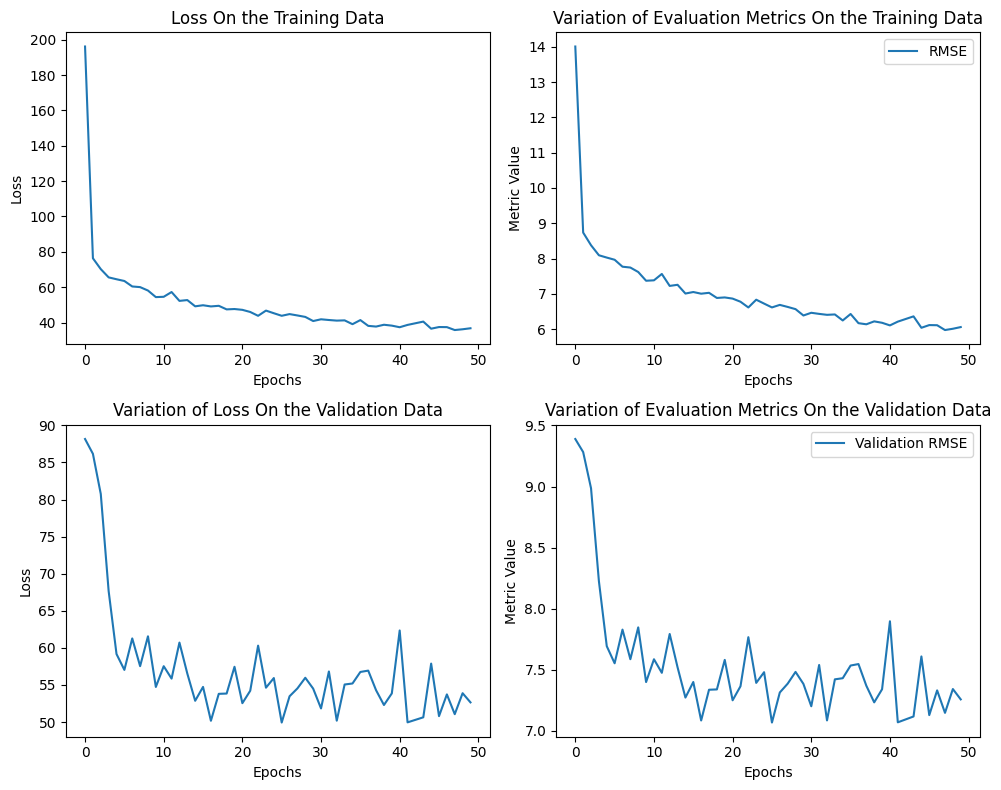

In [50]:
import matplotlib.pyplot as plt

# Plot the loss variation on the training data
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(bmi_final['loss'])
plt.title('Loss On the Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot the variation of MAE and RMSE on the training data
plt.subplot(2, 2, 2)
plt.plot(bmi_final['rmse'], label='RMSE')
plt.title('Variation of Evaluation Metrics On the Training Data')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()

# Plot the loss variation on the validation data
plt.subplot(2, 2, 3)
plt.plot(bmi_final['val_loss'])
plt.title('Variation of Loss On the Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot the variation of MAE and RMSE on the validation data
plt.subplot(2, 2, 4)
plt.plot(bmi_final['vl_rmse'], label='Validation RMSE')
plt.title('Variation of Evaluation Metrics On the Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


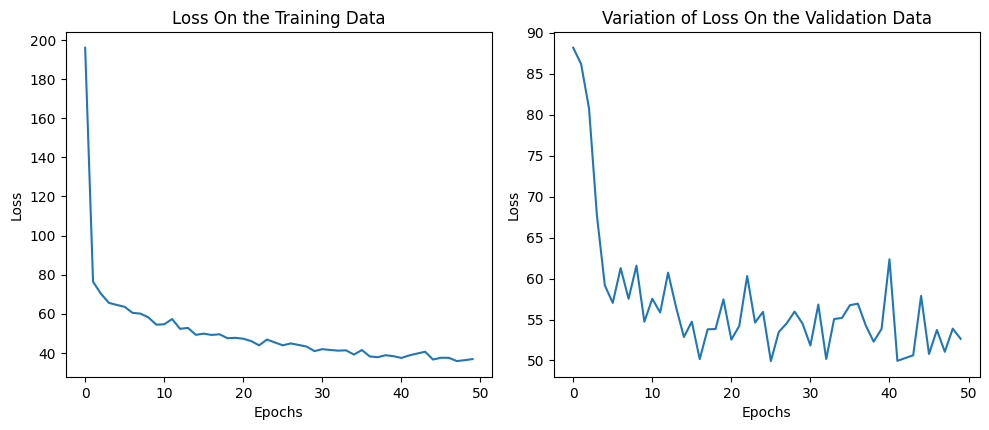

In [53]:
import matplotlib.pyplot as plt

# Plot the loss variation on the training data
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(bmi_final['loss'])
plt.title('Loss On the Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot the loss variation on the validation data
plt.subplot(2, 2, 2)
plt.plot(bmi_final['val_loss'])
plt.title('Variation of Loss On the Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [51]:
bmi_final['vl_rmse'].describe()

count    49.000000
mean      7.543005
std       0.494840
min       7.066253
25%       7.312599
50%       7.398331
75%       7.584720
max       9.389229
Name: vl_rmse, dtype: float64

In [52]:
bmi_final['rmse'].describe()

count    49.000000
mean      6.978139
std       1.231448
min       5.977498
25%       6.248793
50%       6.689943
75%       7.258910
max      14.006326
Name: rmse, dtype: float64